In [1]:
#--------------------------------
## IMPORTS
#--------------------------------
import sys
import os

# set the path to find the modules
#sys.path.insert(0, '../src/') #use relative path
os.chdir("../005_src")

from config_GCN_018 import *

----------------------------------------
Packages import successful
Variables import successful
Helper Functions import successful
Functions import successful
Functions xml import successful
Functions graph import successful
Functions GCN import successful
Functions Data Adjustments import successful
Custom loss imported
Functions Plotting import successful
Functions Plotting import successful
----------------------------------------
root directory: /storage/remote/atcremers50/ss21_multiagentcontrol/
input directory: /storage/remote/atcremers50/ss21_multiagentcontrol/004_data/
output directory: /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/
----------------------------------------

----------------------------------------
root directory: /storage/remote/atcremers50/ss21_multiagentcontrol/
input directory: /storage/remote/atcremers50/ss21_multiagentcontrol/004_data/
output directory: /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/
-------------

In [2]:
#--------------------------------
## WARNINGS MUTED
#--------------------------------
pd.options.mode.chained_assignment = None
plt.rcParams.update({'figure.max_open_warning': 0})


# reasoning

in order to do classification: we need to create classes.
Different options are considered (divide the space according to the vehicle position, in quadrants etc ).
Looking for a easy solution. 
Given that the crossing spans [0-200] in both x and y axes, decision is taken to divide the space into a grid of 100 squares, each one of 20mx20m. This is because:
* the higher the number of classes, the lower the accuracy. Therefore a compromise has to be in place not to have 40.000 classes
* as a minimum we can take the lanes (which come for free from the simulation)
* for a more accurate choice one could look at the distribution of distances driven in 2 seconds by the vehicles in the simulation and choose a binning that makes sense, but at this point the previous estimate does not appear unreasonable ( and timewise affordable).


* select one dataset
* check x and y min and max






In [13]:
### old inputs with intention right, left, u turn
#input_file_name = "20210710-20h38m27s_timesteps14930_ec3500_em7000" #15000
#input_file_name = "20210711-17h59m44s_timesteps30000_ec3500_em7000" #30000
#input_file_name = "20210710-11h46m35s_timesteps200_ec3500_em7000"

### new inputs with intention N,S,E,W,C
input_file_name = "20210724-19h49m31s_timesteps150000_ec3500_em7000"
#input_file_name = "20210725-16h24m21s_timesteps200_ec3500_em7000"

In [14]:
print (f"\n> SELECTING INPUT ROWS")
df_all,df_selected = select_rows_from_data(input_file_name,drop_col = True)
print (f"\n> CORRECTING COLUMNS DATA_POS, DATA_Y_POS, DATA_Y_YAW")

    
# for now we take only the coherent rows
df_input = adjust_columns_2(df_selected)
printif(f"selected {len(df_input)} coherent rows over {len(df_all)} total",printstat)


> SELECTING INPUT ROWS
---------------------------
<class 'pandas.core.frame.DataFrame'>
---------------------------

> CORRECTING COLUMNS DATA_POS, DATA_Y_POS, DATA_Y_YAW
5                                [[False], [False]]
6                                [[False], [False]]
7                                [[False], [False]]
8                                [[False], [False]]
9                                [[False], [False]]
                            ...                    
151193    [[True], [True], [True], [True], [False]]
151194    [[True], [True], [True], [True], [False]]
151195    [[True], [True], [True], [True], [False]]
151196    [[True], [True], [True], [True], [False]]
151197    [[True], [True], [True], [True], [False]]
Name: Still_vehicle, Length: 117648, dtype: object
selected 117648 coherent rows over 144428 total


In [15]:
df_selected.loc[:,"data_x_speed"]= df_selected.apply(lambda x: list_flatten(get_speed_from_data_x(x['data_x'])),axis=1)
all_speeds = list_flatten(df_selected["data_x_speed"])
min(all_speeds), max(all_speeds)

(0.0, 23.48)

In [5]:
df_selected.tail(5)

,data_x,data_pos,data_edges,data_edges_renamed,data_y,data_edges_attr,training_row,Still_vehicle,data_pos_zc,data_y_zc,...,data_x_rad,data_x_speed,data_x_yaw,data_x_intention,data_y_delta,all_veh_moving,num_veh_tot,num_veh_moving,num_veh_still,data_classes
14994,"[[90.0, 0.0, 1.0], [0.0, 15.89, 1.0]]","[[91.8, 98.4], [101.6, 81.11]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 118.0, 0.0]]",[7.8],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.5707963267948966, 0.0, 1.0], [0.0, 15.89, ...","[[0.0], [15.89]]","[90.0, 0.0]","[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 36.89]]",False,2,1,1,"[[44], [54]]"
14995,"[[90.0, 0.0, 1.0], [0.0, 18.05, 1.0]]","[[91.8, 98.4], [101.6, 99.17]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 136.35, 0.0]]",[17.1],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.5707963267948966, 0.0, 1.0], [0.0, 18.05, ...","[[0.0], [18.05]]","[90.0, 0.0]","[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.17999999999999]]",False,2,1,1,[[44]]
14996,"[[90.0, 0.0, 1.0], [0.0, 18.83, 1.0]]","[[91.8, 98.4], [101.6, 118.0]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 155.22, 0.0]]",[7.8],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.5707963267948966, 0.0, 1.0], [0.0, 18.83, ...","[[0.0], [18.83]]","[90.0, 0.0]","[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.22]]",False,2,1,1,"[[44], [55]]"
14997,"[[90.0, 0.0, 1.0], [0.0, 18.35, 1.0]]","[[91.8, 98.4], [101.6, 136.35]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 173.65, 0.0]]",[4.0],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.5707963267948966, 0.0, 1.0], [0.0, 18.35, ...","[[0.0], [18.35]]","[90.0, 0.0]","[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.30000000000001]]",False,2,1,1,"[[44], [56]]"
14998,"[[90.0, 0.0, 1.0], [0.0, 18.87, 1.0]]","[[91.8, 98.4], [101.6, 155.22]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 192.59, 0.0]]",[2.7],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.5707963267948966, 0.0, 1.0], [0.0, 18.87, ...","[[0.0], [18.87]]","[90.0, 0.0]","[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.370000000000005]]",False,2,1,1,"[[44], [57]]"


In [6]:
df_selected.data_pos

5          [[98.4, 183.38], [101.6, 5.1]]
6         [[98.4, 174.92], [101.6, 7.06]]
7          [[98.4, 165.1], [101.6, 11.5]]
8        [[98.4, 152.94], [101.6, 17.33]]
9        [[98.4, 139.08], [101.6, 25.54]]
                       ...               
14994      [[91.8, 98.4], [101.6, 81.11]]
14995      [[91.8, 98.4], [101.6, 99.17]]
14996      [[91.8, 98.4], [101.6, 118.0]]
14997     [[91.8, 98.4], [101.6, 136.35]]
14998     [[91.8, 98.4], [101.6, 155.22]]
Name: data_pos, Length: 11765, dtype: object

### quick check on min and max of y and x

In [7]:
def get_x(data_pos):
    return [data_pos[i][0] for i,veh in enumerate(data_pos)]

def get_y(data_pos):
    return [data_pos[i][1] for i,veh in enumerate(data_pos)]

In [8]:
df_selected_x = df_selected.apply(lambda x: get_x(x['data_pos']),axis=1)
allx_coord = set(list_flatten(df_selected_x.tolist()))
print (f"{min(allx_coord)=}\t{max(allx_coord)=}")

min(allx_coord)=5.1	max(allx_coord)=194.9


In [9]:
df_selected_y = df_selected.apply(lambda x: get_y(x['data_pos']),axis=1)
#print (df_selected_y)
ally_coord = set(list_flatten(df_selected_y.tolist()))
print (f"{min(ally_coord)=}\t{max(ally_coord)=}")

min(ally_coord)=5.1	max(ally_coord)=194.9


In [10]:
# [(0-19),(20-39), ...,(179-199)]

In [11]:
grid_range = [(e, e+19) for e in list(range(0,199,20))]
grid_range

[(0, 19),
 (20, 39),
 (40, 59),
 (60, 79),
 (80, 99),
 (100, 119),
 (120, 139),
 (140, 159),
 (160, 179),
 (180, 199)]

In [12]:
all_ranges_xy = {e:class_num for class_num,e in enumerate(list(product(grid_range,grid_range)))} 
all_ranges_xy

{((0, 19), (0, 19)): 0,
 ((0, 19), (20, 39)): 1,
 ((0, 19), (40, 59)): 2,
 ((0, 19), (60, 79)): 3,
 ((0, 19), (80, 99)): 4,
 ((0, 19), (100, 119)): 5,
 ((0, 19), (120, 139)): 6,
 ((0, 19), (140, 159)): 7,
 ((0, 19), (160, 179)): 8,
 ((0, 19), (180, 199)): 9,
 ((20, 39), (0, 19)): 10,
 ((20, 39), (20, 39)): 11,
 ((20, 39), (40, 59)): 12,
 ((20, 39), (60, 79)): 13,
 ((20, 39), (80, 99)): 14,
 ((20, 39), (100, 119)): 15,
 ((20, 39), (120, 139)): 16,
 ((20, 39), (140, 159)): 17,
 ((20, 39), (160, 179)): 18,
 ((20, 39), (180, 199)): 19,
 ((40, 59), (0, 19)): 20,
 ((40, 59), (20, 39)): 21,
 ((40, 59), (40, 59)): 22,
 ((40, 59), (60, 79)): 23,
 ((40, 59), (80, 99)): 24,
 ((40, 59), (100, 119)): 25,
 ((40, 59), (120, 139)): 26,
 ((40, 59), (140, 159)): 27,
 ((40, 59), (160, 179)): 28,
 ((40, 59), (180, 199)): 29,
 ((60, 79), (0, 19)): 30,
 ((60, 79), (20, 39)): 31,
 ((60, 79), (40, 59)): 32,
 ((60, 79), (60, 79)): 33,
 ((60, 79), (80, 99)): 34,
 ((60, 79), (100, 119)): 35,
 ((60, 79), (120, 13

In [13]:
test_points = [(10,10),(30,30),(170,170)]
classes_points = []
for p in test_points:
    print ("-----------------------")
    #print (p)
    for range_xy in list(all_ranges_xy.keys()):
        #print (range_xy)
        range_x = range_xy[0]
        range_y = range_xy[1]
        if (range_x[0]<= p[0] <= range_x[1]) and (range_y[0]<= p[1] <= range_y[1]):
            classes_points.append(all_ranges_xy[range_xy])
            #print ()
            print (classes_points)
            #pdb.set_trace()
            break
            


-----------------------
[0]
-----------------------
[0, 11]
-----------------------
[0, 11, 88]


In [41]:
def create_grid_range(min_value = 0,
                      max_value = 199, 
                      delta = 20):
    grid_range = [(e, e+20) for e in list(range(min_value,max_value,delta))]
    all_ranges_xy = {e:class_num for class_num,e in enumerate(list(product(grid_range,grid_range)))}
    
    return all_ranges_xy

def get_classes_for_point_list(point_list,printstat = False):
    
    all_ranges_xy = create_grid_range()
    classes_points = []
    printif (f" ", printstat)
    for p in point_list:
        printif (f"{p=}", printstat)
        for i,range_xy in enumerate(list(all_ranges_xy.keys())):
            range_x = range_xy[0]
            range_y = range_xy[1]
            #printif (f"{range_x=},{range_y=}", printstat)
            if (range_x[0]<= p[0] <= range_x[1]) and (range_y[0]<= p[1] <= range_y[1]):
                printif (f"{all_ranges_xy[range_xy]=}", printstat)
                classes_points.append([all_ranges_xy[range_xy]])
                break
    #pdb.set_trace()
    return classes_points

# function to create classes
def get_all_classes(data_pos,printstat = False):
    return get_classes_for_point_list(data_pos,printstat = printstat)

In [42]:
all_ranges_xy = create_grid_range()

In [43]:
df_input[['data_pos','data_classes','data_y']].head(5)

,data_pos,data_classes,data_y
5,"[[98.4, 183.38], [101.6, 5.1]]","[[49], [50]]","[[98.4, 165.1, 180.0], [101.6, 11.5, 0.0]]"
6,"[[98.4, 174.92], [101.6, 7.06]]","[[48], [50]]","[[98.4, 152.94, 180.0], [101.6, 17.33, 0.0]]"
7,"[[98.4, 165.1], [101.6, 11.5]]","[[48], [50]]","[[98.4, 139.08, 180.0], [101.6, 25.54, 0.0]]"
8,"[[98.4, 152.94], [101.6, 17.33]]","[[47], [50]]","[[98.4, 123.22, 180.0], [101.6, 35.19, 0.0]]"
9,"[[98.4, 139.08], [101.6, 25.54]]",[[51]],"[[98.4, 105.61, 180.0], [101.6, 46.24, 0.0]]"


In [44]:
#all_ranges_xy.keys() #[(98.4, 139.08)]

In [45]:
df_input.apply(lambda x: get_all_classes(x['data_y'], False),axis=1)

5        [[48], [50]]
6        [[47], [50]]
7        [[46], [51]]
8        [[46], [51]]
9        [[45], [52]]
             ...     
14994    [[44], [55]]
14995    [[44], [56]]
14996    [[44], [57]]
14997    [[44], [58]]
14998    [[44], [59]]
Length: 11765, dtype: object

In [46]:
df_input.data_pos.iloc[0]

[[98.4, 183.38], [101.6, 5.1]]

In [47]:
get_classes_for_point_list(df_input.data_pos.iloc[0])

[[49], [50]]

In [48]:
get_classes_for_point_list(df_input.data_y.iloc[0])

[[48], [50]]

In [49]:
data_classes = df_input.apply(lambda x: get_all_classes(x['data_pos']),axis=1)
df_input.loc[:,"data_classes"] = data_classes
data_y_classes = df_input.apply(lambda x: get_all_classes(x['data_y']),axis=1)
df_input.loc[:,"data_y_classes"] = data_y_classes
df_input[['data_pos','data_classes','data_y','data_y_classes']]

,data_pos,data_classes,data_y,data_y_classes
5,"[[98.4, 183.38], [101.6, 5.1]]","[[49], [50]]","[[98.4, 165.1, 180.0], [101.6, 11.5, 0.0]]","[[48], [50]]"
6,"[[98.4, 174.92], [101.6, 7.06]]","[[48], [50]]","[[98.4, 152.94, 180.0], [101.6, 17.33, 0.0]]","[[47], [50]]"
7,"[[98.4, 165.1], [101.6, 11.5]]","[[48], [50]]","[[98.4, 139.08, 180.0], [101.6, 25.54, 0.0]]","[[46], [51]]"
8,"[[98.4, 152.94], [101.6, 17.33]]","[[47], [50]]","[[98.4, 123.22, 180.0], [101.6, 35.19, 0.0]]","[[46], [51]]"
9,"[[98.4, 139.08], [101.6, 25.54]]","[[46], [51]]","[[98.4, 105.61, 180.0], [101.6, 46.24, 0.0]]","[[45], [52]]"
...,...,...,...,...
14994,"[[91.8, 98.4], [101.6, 81.11]]","[[44], [54]]","[[91.8, 98.4, 90.0], [101.6, 118.0, 0.0]]","[[44], [55]]"
14995,"[[91.8, 98.4], [101.6, 99.17]]","[[44], [54]]","[[91.8, 98.4, 90.0], [101.6, 136.35, 0.0]]","[[44], [56]]"
14996,"[[91.8, 98.4], [101.6, 118.0]]","[[44], [55]]","[[91.8, 98.4, 90.0], [101.6, 155.22, 0.0]]","[[44], [57]]"
14997,"[[91.8, 98.4], [101.6, 136.35]]","[[44], [56]]","[[91.8, 98.4, 90.0], [101.6, 173.65, 0.0]]","[[44], [58]]"


In [50]:
from collections import Counter
all_classes_list = list_flatten(list_flatten(list(data_classes)))
occupied_classes = set(all_classes_list)
Counter(all_classes_list)

Counter({49: 1024,
         50: 1023,
         48: 538,
         47: 419,
         46: 1553,
         51: 506,
         4: 1335,
         45: 8439,
         52: 394,
         44: 10143,
         43: 321,
         53: 1525,
         42: 203,
         54: 8015,
         14: 687,
         57: 368,
         24: 708,
         95: 1367,
         34: 3243,
         85: 691,
         75: 688,
         65: 3146,
         55: 9500,
         56: 522,
         35: 513,
         25: 404,
         64: 228,
         58: 84,
         74: 113,
         41: 32,
         84: 26,
         15: 118})

In [55]:
all_classes_list_y = list_flatten(list_flatten(list(data_y_classes)))
occupied_classes_y = set(all_classes_list_y)
Counter(all_classes_list_y)

Counter({48: 519,
         50: 511,
         47: 415,
         46: 1557,
         51: 516,
         45: 8471,
         52: 403,
         44: 10172,
         4: 665,
         43: 396,
         53: 1542,
         42: 283,
         54: 7987,
         14: 689,
         41: 223,
         55: 9578,
         40: 177,
         56: 637,
         24: 710,
         58: 317,
         95: 689,
         59: 345,
         85: 704,
         75: 698,
         65: 3133,
         57: 457,
         34: 3222,
         35: 568,
         25: 384,
         15: 367,
         5: 345,
         64: 241,
         74: 194,
         49: 511,
         84: 146,
         94: 104})

In [57]:
# function to create classes
def get_len_classes(data_classes,):
    return len(data_classes)

df_input.loc[:,"len_data_classes"]= df_input.apply(lambda x: get_len_classes(x['data_classes']),axis=1)
df_input["len_data_classes"]


df_input.loc[:,"len_data_y_classes"]= df_input.apply(lambda x: get_len_classes(x['data_y_classes']),axis=1)
df_input["len_data_y_classes"]

5        2
6        2
7        2
8        2
9        2
        ..
14994    2
14995    2
14996    2
14997    2
14998    2
Name: len_data_y_classes, Length: 11765, dtype: int64

In [58]:
df_input

,data_x,data_pos,data_edges,data_edges_renamed,data_y,data_edges_attr,training_row,Still_vehicle,data_pos_zc,data_y_zc,...,data_x_intention,data_y_delta,all_veh_moving,num_veh_tot,num_veh_moving,num_veh_still,data_classes,data_y_classes,len_data_classes,len_data_y_classes
5,"[[180.0, 6.25, 1.0], [0.0, 0.0, 1.0]]","[[98.4, 183.38], [101.6, 5.1]]","[[0], [1]]","[[0], [1]]","[[98.4, 165.1, 180.0], [101.6, 11.5, 0.0]]",[1.4000000000000001],True,"[[False], [False]]","[[-1.5999999999999943, 83.38], [1.599999999999...","[[-1.5999999999999943, 65.1], [1.5999999999999...",...,"[[1.0], [1.0]]","[[0.0, -18.28], [0.0, 6.400000000000006]]",True,2,2,0,"[[49], [50]]","[[48], [50]]",2,2
6,"[[180.0, 8.46, 1.0], [0.0, 1.96, 1.0]]","[[98.4, 174.92], [101.6, 7.06]]","[[0], [1]]","[[0], [1]]","[[98.4, 152.94, 180.0], [101.6, 17.33, 0.0]]",[1.4000000000000001],True,"[[False], [False]]","[[-1.5999999999999943, 74.91999999999999], [1....","[[-1.5999999999999943, 52.94], [1.599999999999...",...,"[[1.0], [1.0]]","[[0.0, -21.97999999999999], [0.0, 10.269999999...",True,2,2,0,"[[48], [50]]","[[47], [50]]",2,2
7,"[[180.0, 9.82, 1.0], [0.0, 4.44, 1.0]]","[[98.4, 165.1], [101.6, 11.5]]","[[0], [1]]","[[0], [1]]","[[98.4, 139.08, 180.0], [101.6, 25.54, 0.0]]",[1.4000000000000001],True,"[[False], [False]]","[[-1.5999999999999943, 65.1], [1.5999999999999...","[[-1.5999999999999943, 39.08000000000001], [1....",...,"[[1.0], [1.0]]","[[0.0, -26.019999999999982], [0.0, 14.03999999...",True,2,2,0,"[[48], [50]]","[[46], [51]]",2,2
8,"[[180.0, 12.16, 1.0], [0.0, 5.83, 1.0]]","[[98.4, 152.94], [101.6, 17.33]]","[[0], [1]]","[[0], [1]]","[[98.4, 123.22, 180.0], [101.6, 35.19, 0.0]]",[1.6],True,"[[False], [False]]","[[-1.5999999999999943, 52.94], [1.599999999999...","[[-1.5999999999999943, 23.22], [1.599999999999...",...,"[[1.0], [1.0]]","[[0.0, -29.72], [0.0, 17.86]]",True,2,2,0,"[[47], [50]]","[[46], [51]]",2,2
9,"[[180.0, 13.86, 1.0], [0.0, 8.21, 1.0]]","[[98.4, 139.08], [101.6, 25.54]]","[[0], [1]]","[[0], [1]]","[[98.4, 105.61, 180.0], [101.6, 46.24, 0.0]]",[1.7000000000000002],True,"[[False], [False]]","[[-1.5999999999999943, 39.08000000000001], [1....","[[-1.5999999999999943, 5.609999999999999], [1....",...,"[[1.0], [1.0]]","[[0.0, -33.47000000000001], [0.0, 20.700000000...",True,2,2,0,"[[46], [51]]","[[45], [52]]",2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,"[[90.0, 0.0, 1.0], [0.0, 15.89, 1.0]]","[[91.8, 98.4], [101.6, 81.11]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 118.0, 0.0]]",[7.8],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 36.89]]",False,2,1,1,"[[44], [54]]","[[44], [55]]",2,2
14995,"[[90.0, 0.0, 1.0], [0.0, 18.05, 1.0]]","[[91.8, 98.4], [101.6, 99.17]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 136.35, 0.0]]",[17.1],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.17999999999999]]",False,2,1,1,"[[44], [54]]","[[44], [56]]",2,2
14996,"[[90.0, 0.0, 1.0], [0.0, 18.83, 1.0]]","[[91.8, 98.4], [101.6, 118.0]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 155.22, 0.0]]",[7.8],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.22]]",False,2,1,1,"[[44], [55]]","[[44], [57]]",2,2
14997,"[[90.0, 0.0, 1.0], [0.0, 18.35, 1.0]]","[[91.8, 98.4], [101.6, 136.35]]","[[1434], [1435]]","[[0], [1]]","[[91.8, 98.4, 90.0], [101.6, 173.65, 0.0]]",[4.0],True,"[[True], [False]]","[[-8.200000000000003, -1.5999999999999943], [1...","[[-8.200000000000003, -1.5999999999999943], [1...",...,"[[1.0], [1.0]]","[[0.0, 0.0], [0.0, 37.30000000000001]]",False,2,1,1,"[[44], [56]]","[[44], [58]]",2,2


## sanity check

In [59]:
mask = df_input["len_data_classes"] ==0
df_input[mask]

,data_x,data_pos,data_edges,data_edges_renamed,data_y,data_edges_attr,training_row,Still_vehicle,data_pos_zc,data_y_zc,...,data_x_intention,data_y_delta,all_veh_moving,num_veh_tot,num_veh_moving,num_veh_still,data_classes,data_y_classes,len_data_classes,len_data_y_classes


In [60]:
mask = df_input["len_data_y_classes"] ==0
df_input[mask]

,data_x,data_pos,data_edges,data_edges_renamed,data_y,data_edges_attr,training_row,Still_vehicle,data_pos_zc,data_y_zc,...,data_x_intention,data_y_delta,all_veh_moving,num_veh_tot,num_veh_moving,num_veh_still,data_classes,data_y_classes,len_data_classes,len_data_y_classes


In [61]:
mask = df_input["len_data_y_classes"] != df_input["len_data_classes"]
df_input[mask]

,data_x,data_pos,data_edges,data_edges_renamed,data_y,data_edges_attr,training_row,Still_vehicle,data_pos_zc,data_y_zc,...,data_x_intention,data_y_delta,all_veh_moving,num_veh_tot,num_veh_moving,num_veh_still,data_classes,data_y_classes,len_data_classes,len_data_y_classes


## plot

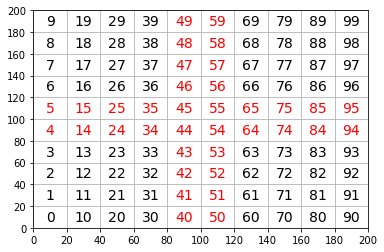

In [56]:
fig, ax = plt.subplots()
ax.set_xticks(list(range(0,201,20)), minor=False)
ax.set_xticks(list(range(0,201,20)), minor=True)
ax.xaxis.grid(True, which='major')
ax.xaxis.grid(True, which='minor')
ax.set_yticks(list(range(0,201,20)), minor=False)
ax.set_yticks(list(range(0,201,20)), minor=True)
ax.yaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

all_ranges_xy = create_grid_range()
for k,v in all_ranges_xy.items():
    #print (k,v)
    if v in occupied_classes_y:
        color = "red"
    else: 
        color = "black"
    ax.annotate(str(v), ((k[0][0]+k[0][1])/2, (k[1][0]+k[1][1])/2), ha='center', va='center', size=14, color = color)
plt.show()

In [24]:
mytensor = df_input.data_classes.iloc[0]
mytensor = torch.from_numpy(np.asarray(mytensor))
mytensor,mytensor.shape

(tensor([[49],
         [50]]),
 torch.Size([2, 1]))

In [25]:
mytensor.reshape(1,2)

tensor([[49, 50]])

In [26]:
mytensor.transpose(0, 1)

tensor([[49, 50]])

In [27]:
mytensor.flatten(0)

tensor([49, 50])

In [28]:
mytensor.view(-1)

tensor([49, 50])